# Advanced Linear Regression Assignment

# Business Problem

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them at a higher price. For the same purpose, the company has collected a data set from the sale of houses in Australia.
The company is looking at prospective properties to buy to enter the market.

## Analysis Requirement 

1. Variables are significant in predicting the price of a house.
2. How the variables describe the price of a house.
3. The optimal value of lambda for ridge and lasso regression.

### Approach / Outline

1. Understanding Data
    * Reading the dataset
    * Check Missing Values.
    * Dropping Columns with High Missing Values
    * Imputation of meaningful variables.
    * Imputation with statistical values.
    * Outlier Handling  
    
    
2. Visualize Data (EDA)
    * Univariate Analysis
    * Segmented Univariate Analysis
    * Bivariate Analysis
    * Covariate Analysis  
    

3. Data Transformation
    * Order Nominal Categorical variable
    * Dummy Variables
    * Derived Features  
    

4. Dataset Creation
    * Splitting Dataset
    * Feature Scaling    


5. Modelling
    * Linear Regression Baseline
    * RFE feature Selection
    * Ridge Regression (RFE Features)
    * Ridge Regression (All Features)
    * LASSO Regression (RFE Features)
    * LASSO (All Features)
    * Model Performance Comparison 
    * Reporting Optimal Alpha    
    

6. Model Evaluation & Selection
    * Y-test v/s Y-Pred
    * Error Term Analysis  
    

7. Significant Features
    * Train Best Model
    * Significant Features of the model  

## Step 0 : Imports & Utility Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

import os
import datetime
from scipy import stats
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV,KFold,cross_val_score
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

# hide warnings
import warnings
warnings.filterwarnings('ignore')

## Step 1 : Understanding Data

### Reading | Understanding | Cleaning | Transformation

In [2]:
# reading the dataset
data = pd.read_csv("train.csv")

# Dataset Dimensions
print("Data Size Read: {}".format(data.shape))

# Drop Duplicate data if present
data = data.drop_duplicates()
print("Data Size after De-Dup: {}".format(data.shape))
# Look at the data
data.head(3)

Data Size Read: (1460, 81)
Data Size after De-Dup: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
# Computing Null/Missing values for dataset
def check_missing_values(data) :
    col_list = list(data)
    null = []
    for value in data.isnull().sum()*100/data.shape[0]:
        null.append(value)
    data_dict = {'column': col_list, 'null_precent': null}
    data_null = pd.DataFrame(data_dict)

    data_null = data_null.sort_values(by='null_precent',ascending=False)    
    return data_null[data_null['null_precent'] != 0]

# Check % of missing data
check_missing_values(data)

,column,null_precent
72,PoolQC,99.520548
74,MiscFeature,96.301370
6,Alley,93.767123
73,Fence,80.753425
57,FireplaceQu,47.260274
3,LotFrontage,17.739726
59,GarageYrBlt,5.547945
64,GarageCond,5.547945
58,GarageType,5.547945
60,GarageFinish,5.547945


#### Summary :
    1. We can see that the columns : "PoolQC","MiscFeature","Alley","Fence" has over 80% missing values
    2. We will be dropping these features
    3. Also, the "Id" is just an Identifier & not predictor. So we will drop that as well.
    4. We can notice, some columns have a consistent **null_precent** : at either 5.54795 or 2.534247
    5. Based on the data description and it was found :
        i. 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'  are nan because the house don't have a garage
        ii. 'BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtFinType1', 'BsmtCond' are nan because the houses don't have a basement.
        iii. For FireplaceQu, NA means No FirePlace. So we change that as well.
        iv. It's note worthy to see MasVnrType & MasVnrArea are having same missing values as Garage. But the relationship is not known. So not filling them.
        v. MasVnrType has a Category as "NONE" so filling it with the string category "NONE"
    6. For these we would properly define a categorical value

In [4]:
# Drop Columns in Place
print('Shape of the orginal data:', data.shape)
data = data.drop(['Id','Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis = 1)
print('Shape after dropping:', data.shape)

Shape of the orginal data: (1460, 81)
Shape after dropping: (1460, 76)


In [5]:
# Fill NANs for Numerical Columns

# for no Garage 
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    data[col].fillna('No Garage', inplace=True)
data['GarageYrBlt'].fillna(0, inplace=True)

# for no Basement
for col in ['BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtFinType1', 'BsmtCond']:
    data[col].fillna('No Basement', inplace=True)

#Filling the NANs in 'FireplaceQu' with the most frequent value 'No Fireplace'
data['FireplaceQu'].fillna('No Fireplace', inplace=True)

# Filling NONE with String Category None
data['MasVnrType'].fillna('None', inplace=True)
check_missing_values(data)

,column,null_precent
2,LotFrontage,17.739726
24,MasVnrArea,0.547945
40,Electrical,0.068493


count    1452.000000
mean      103.685262
std       181.066207
min         0.000000
25%         0.000000
50%         0.000000
75%       166.000000
90%       335.000000
95%       456.000000
99%       791.920000
max      1600.000000
Name: MasVnrArea, dtype: float64

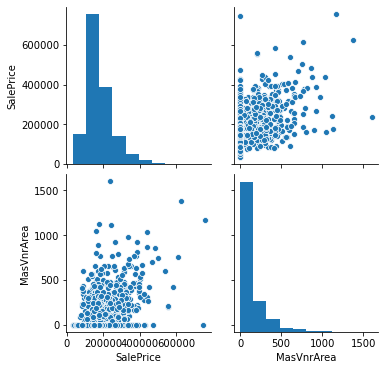

In [6]:
# Checking Relationship b/w SalePrice & MasVnrArea
sns.pairplot(data[['SalePrice','MasVnrArea']])

# Checking Distribution for  MasVnrArea.
data['MasVnrArea'].describe([0.25,0.50,0.75,0.90,0.95,0.99])

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
90%        96.000000
95%       107.000000
99%       141.000000
max       313.000000
Name: LotFrontage, dtype: float64

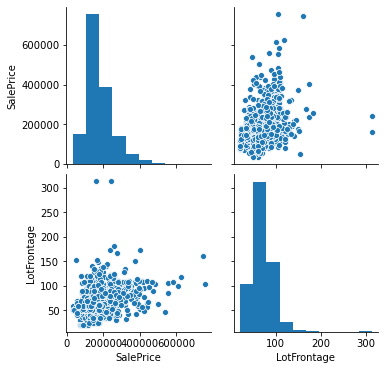

In [7]:
# Since LotFrontage has 17% missing values, let's check it's relationship with SalesPrice.
sns.pairplot(data[['SalePrice','LotFrontage']])

data['LotFrontage'].describe([0.25,0.50,0.75,0.90,0.95,0.99])

In [8]:
# As we can see LotFrontage & MasVnrArea  is skewed, we would hence impute it with Median
data['LotFrontage'].fillna(data['LotFrontage'].median(),inplace=True)
data['MasVnrArea'].fillna(data['MasVnrArea'].median(),inplace=True)

In [9]:
# Check which Columns have repititive values. i.e. The same value occuring for X % of the datapoints

threshold = 0.98
drop_columns = []
for column in data.columns :
    unique_data = pd.DataFrame(data[column].value_counts()).reset_index()
    values = unique_data[column].tolist()
    
    for value in values :
        common_percent = value/data.shape[0]
        if value/data.shape[0] > threshold :
            print("Column : {} has {} % values same.".format(column,round(common_percent,3)))
            drop_columns.append(column)

# We will drop these columns
data = data.drop(drop_columns, axis = 1)
print("Data Size : {}".format(data.shape))            

Column : Street has 0.996 % values same.
Column : Utilities has 0.999 % values same.
Column : Condition2 has 0.99 % values same.
Column : RoofMatl has 0.982 % values same.
Column : LowQualFinSF has 0.982 % values same.
Column : 3SsnPorch has 0.984 % values same.
Column : PoolArea has 0.995 % values same.
Data Size : (1460, 69)


In [10]:
# Check remaining Missing Data
check_missing_values(data)

,column,null_precent
36,Electrical,0.068493


In [11]:
# As we just have 1 instance of missing value, we will drop this row/datapoint from our dataset
data.dropna(axis='rows', inplace=True)
check_missing_values(data)

,column,null_precent


In [12]:
# Finally we would just like to have a look at our Categorical & Numerical features

column_info = pd.DataFrame(data.dtypes).reset_index()
num_col = column_info['index'][column_info[0] !='object'].tolist()
cat_col = column_info['index'][column_info[0] =='object'].tolist()

prediction_col = num_col[-1]
num_col=num_col[:-1]

print("Column to Predict  : {}".format(prediction_col))
print()
print("Numerical Columns : {}".format(num_col))
print()
print("Categorical Columns : {}".format(cat_col))

Column to Predict  : SalePrice

Numerical Columns : ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MiscVal', 'MoSold', 'YrSold']

Categorical Columns : ['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleT

In [13]:
# Eliminating Outliers > +3 Std. Deviation or < -3 Std. Deviation 
# Compute
print("Data Size with Outliers : {}".format(data.shape))
z = np.abs(stats.zscore(data[num_col]))

# Outlier Removed Records
selected_data = data[num_col][(z < 3).all(axis=1)]

# indexing to keep selected data
data = data.loc[selected_data.index]

print("Data Size after removing Outliers : {}".format(data.shape))

Data Size with Outliers : (1459, 69)
Data Size after removing Outliers : (1003, 69)


## Step 2 : Visualize Data (EDA)

In [14]:
# Univariate Analysis of Numerical column
def num_col_analysis(idx, x_col,y_col,data):
#     plt.subplot(17,2,idx)
    plt.figure(idx+1)
    sns.jointplot(x=x_col, y=y_col, data=data[[x_col,y_col]])
    
# Univariate Analysis of Numerical column
def cat_col_analysis(idx, x_col,y_col,data):
    plt.subplot(18,2,idx)
    sns.boxplot(x=x_col, y=y_col, data=data[[x_col,y_col]])

<Figure size 2160x14400 with 0 Axes>

<Figure size 432x288 with 0 Axes>

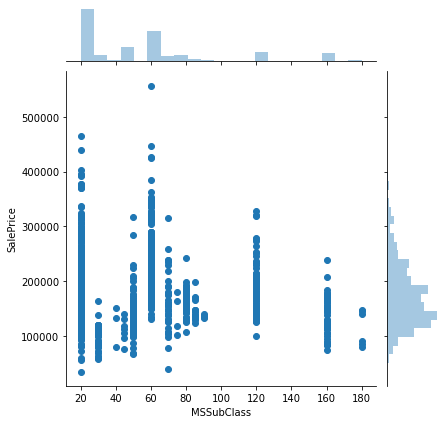

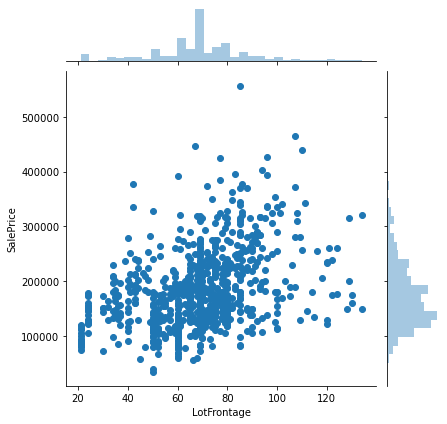

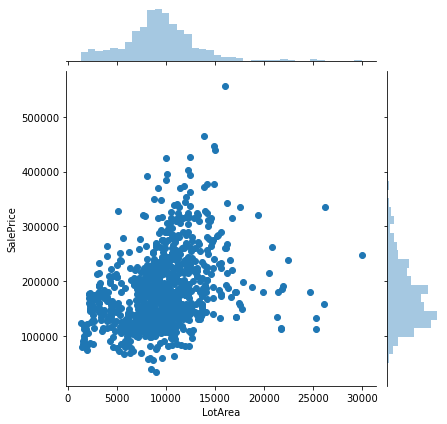

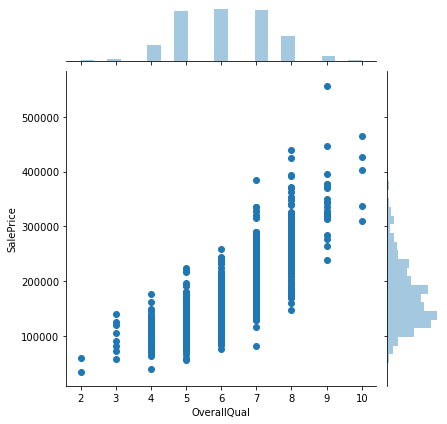

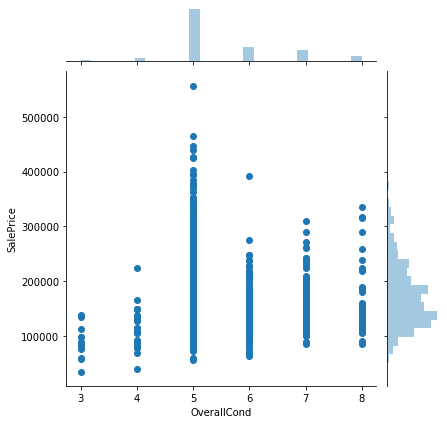

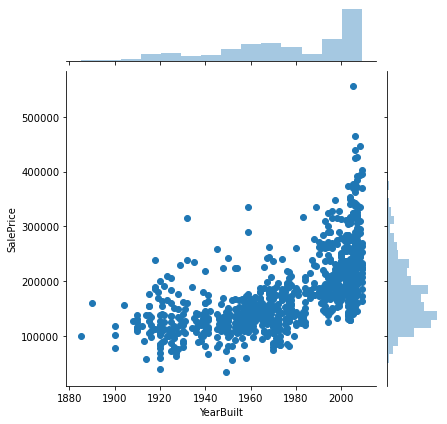

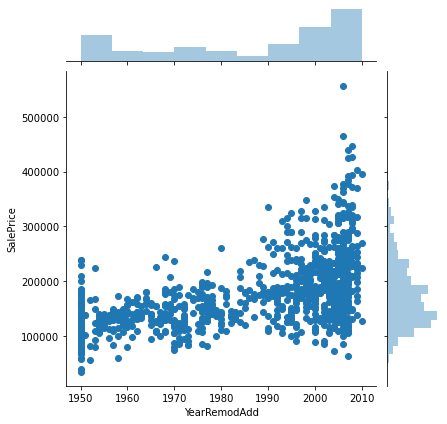

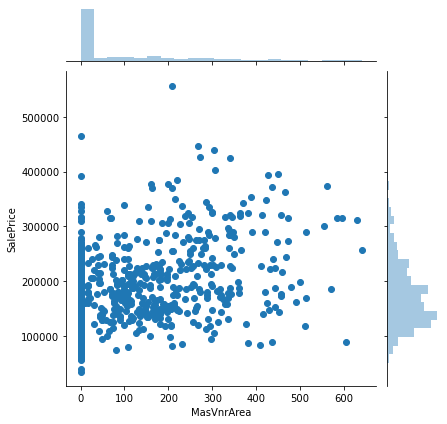

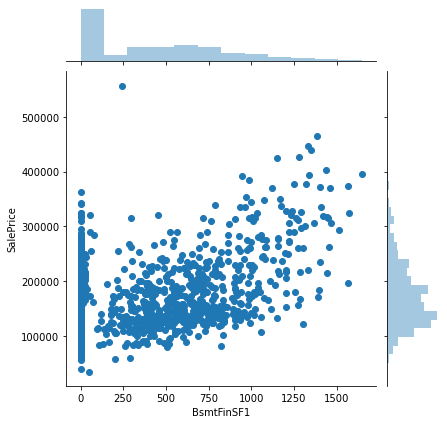

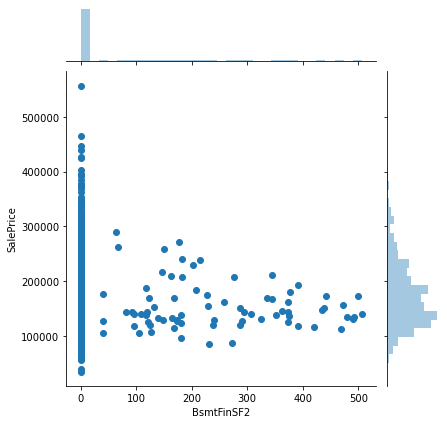

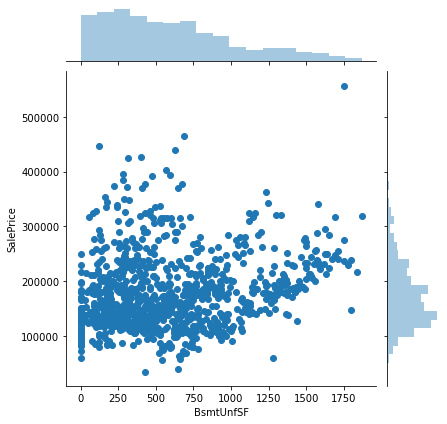

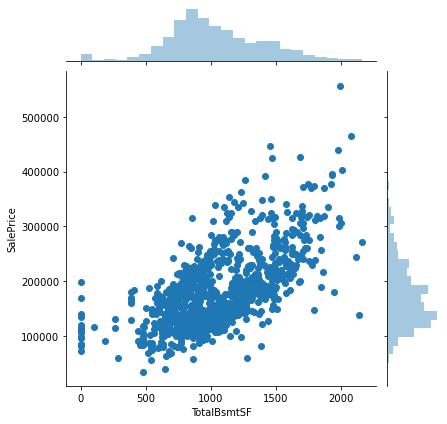

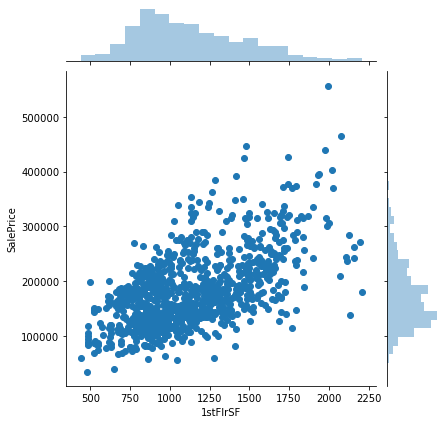

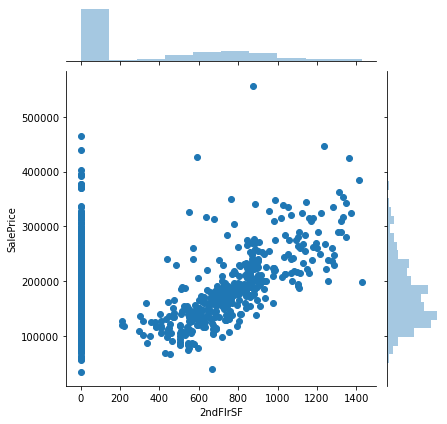

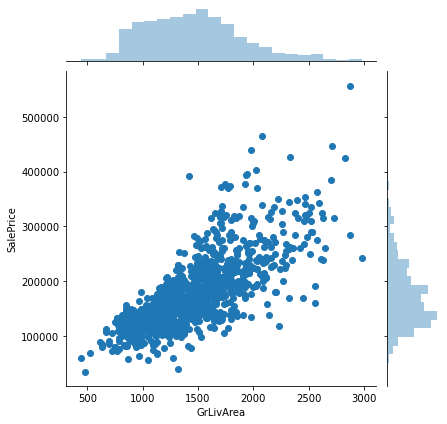

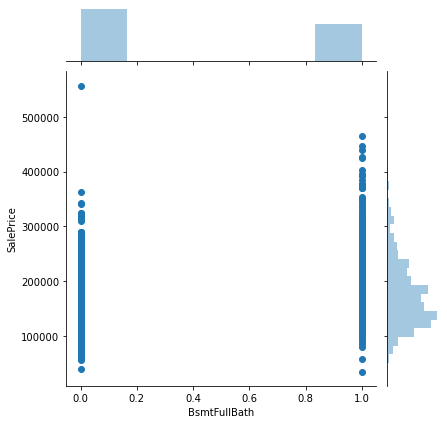

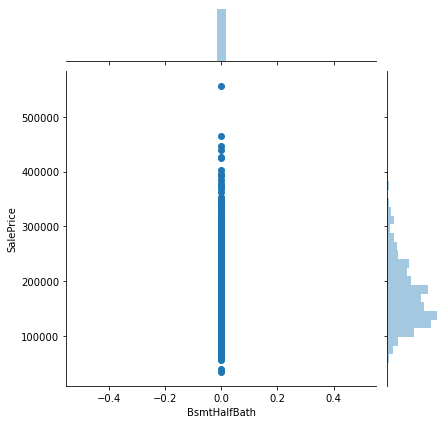

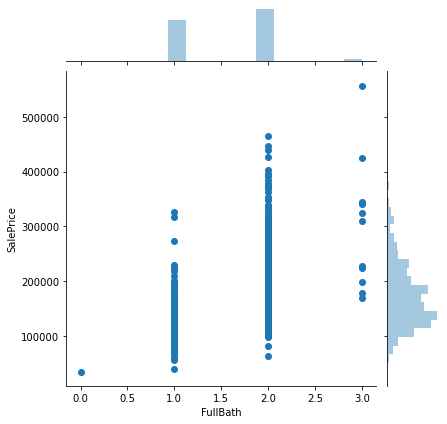

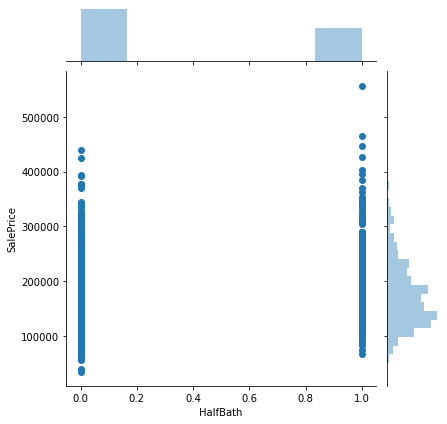

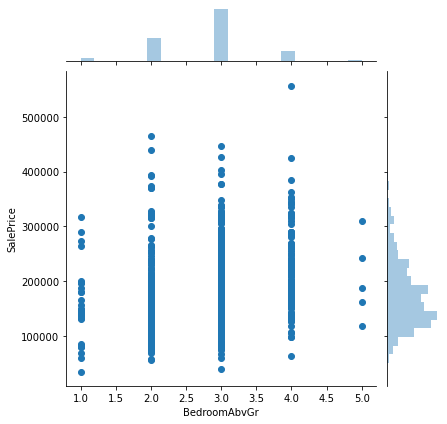

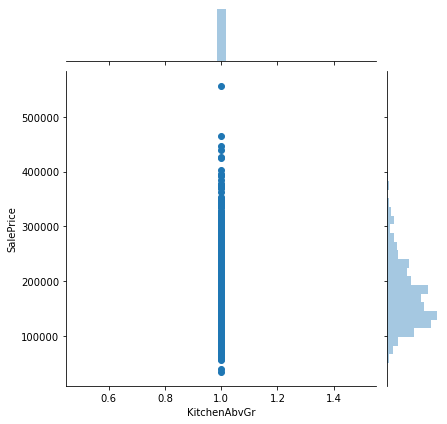

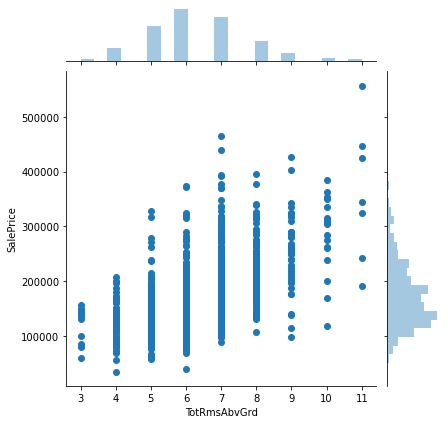

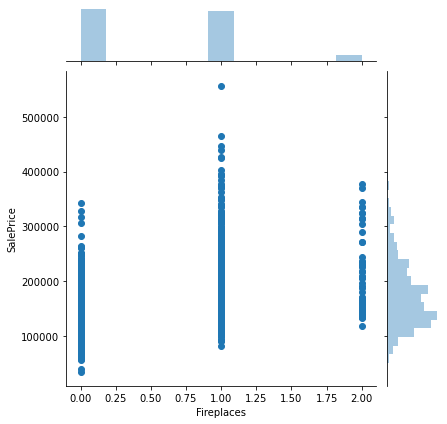

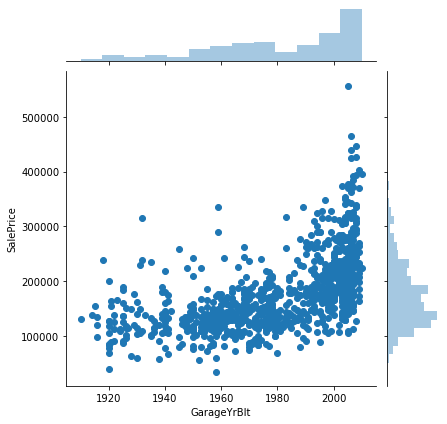

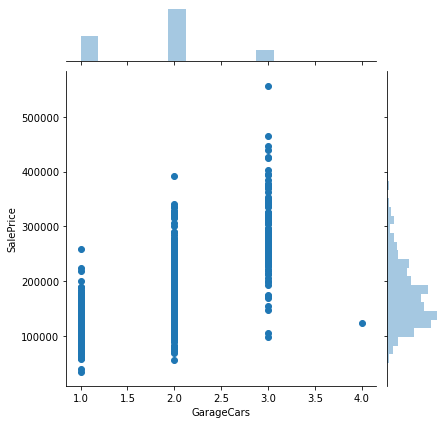

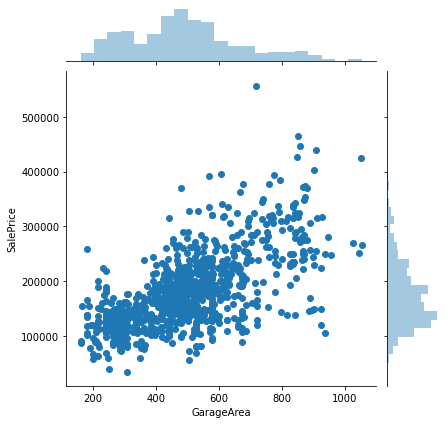

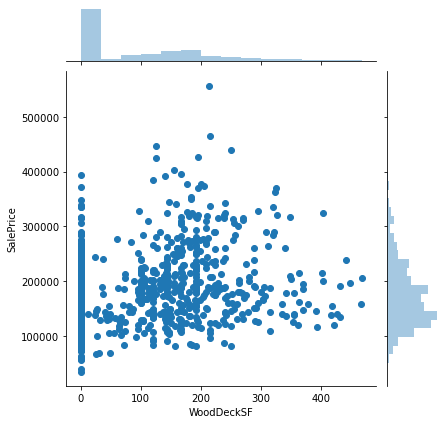

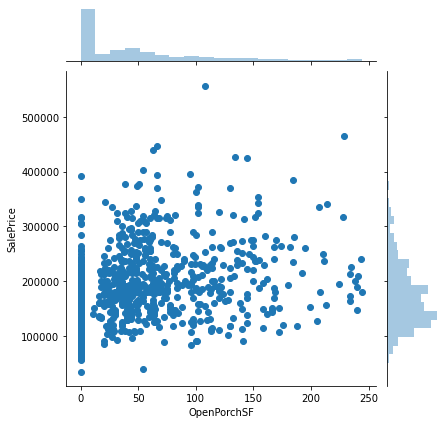

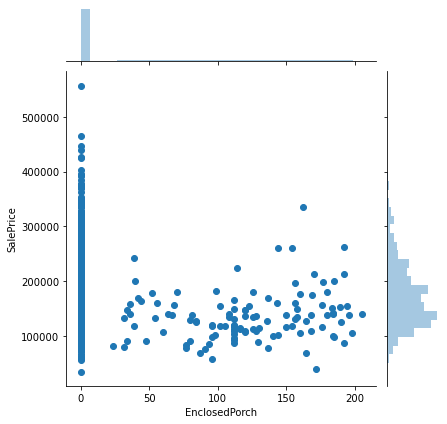

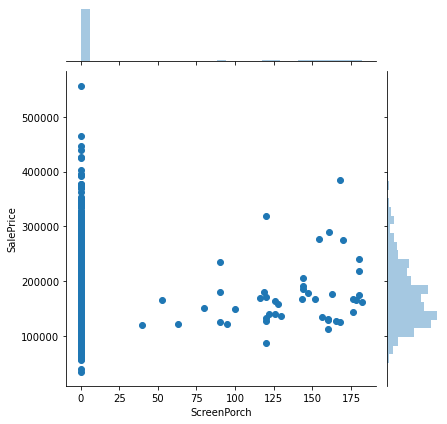

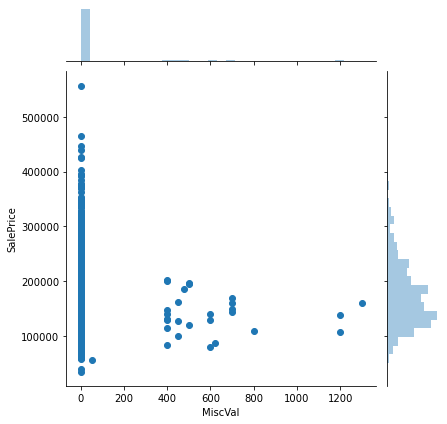

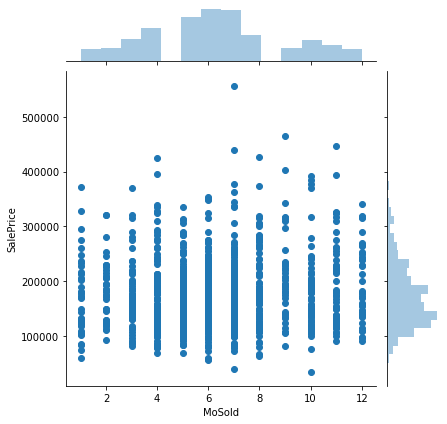

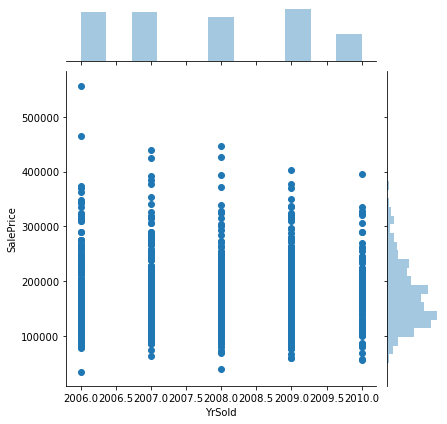

In [15]:
plt.figure(figsize=(30, 200))
for idx,col in enumerate(num_col) :
    num_col_analysis(idx+1,col,prediction_col,data)

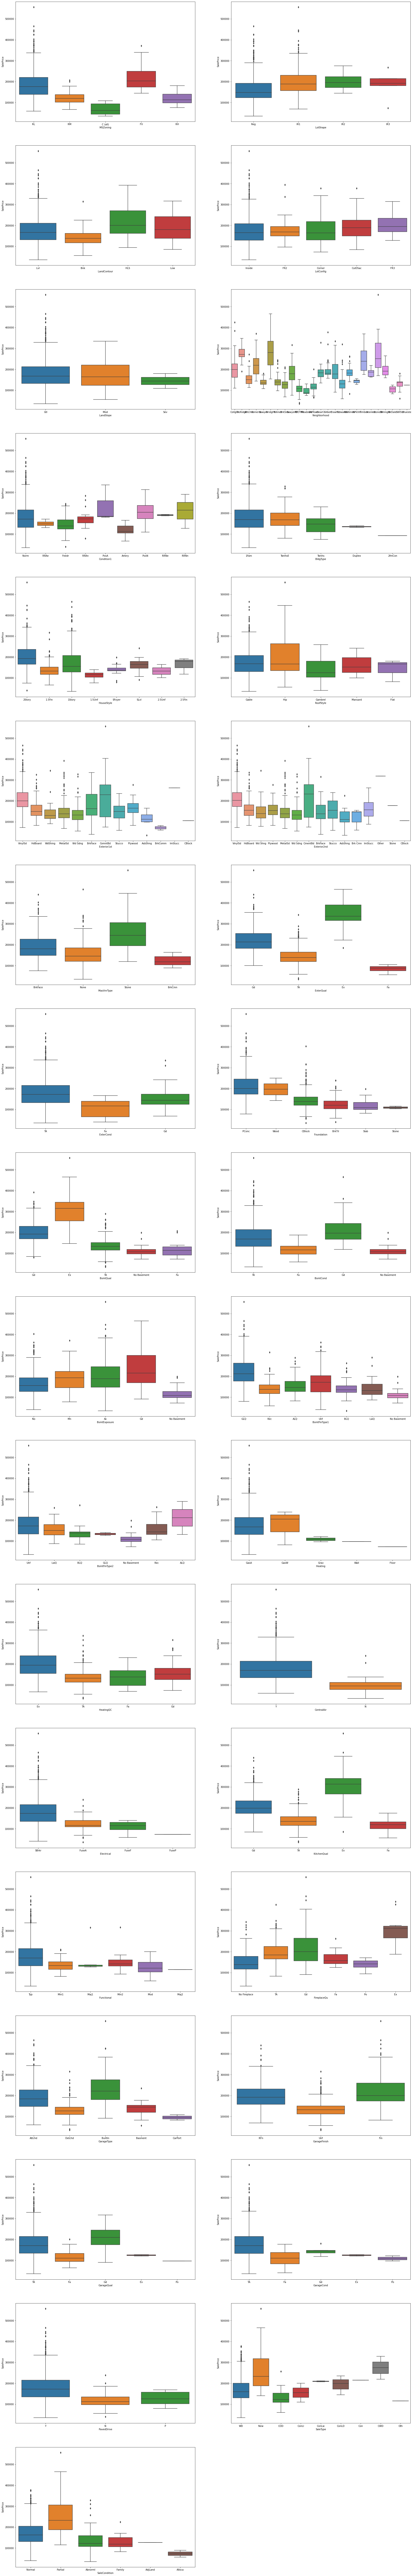

In [16]:
# Box Blots for Categorical Values againsts Target variable
plt.figure(figsize=(30, 200))
for idx,col in enumerate(cat_col) :
    cat_col_analysis(idx+1,col,prediction_col,data)

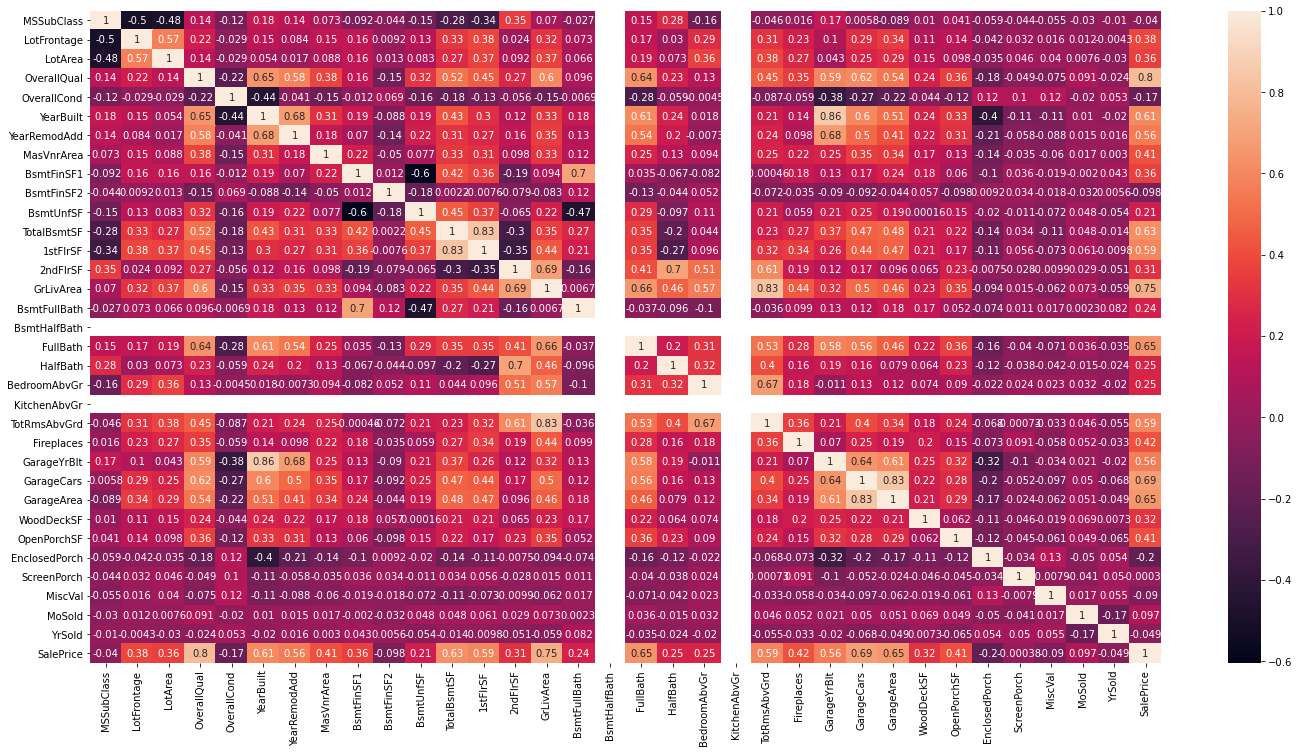

In [17]:
## Correlation Matrix among features
plt.figure(figsize=(24, 12))
sns.heatmap(data.corr(), annot = True)

In [18]:
# As the heatmap is very condensed let's do some filtering

# Identifying highly correlated varaibles
corr_matrix = data.corr()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Columns with high  +ve Correlation 
cols_pos = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.80)]
cols_neg = [col for col in upper_triangle.columns if any(upper_triangle[col] < -0.40)]
print("Features with Positive Co-relation : {}".format(cols_pos))
print("Features with Negative Co-relation : {}".format(cols_neg))


Features with Positive Co-relation : ['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea', 'SalePrice']
Features with Negative Co-relation : ['LotFrontage', 'LotArea', 'YearBuilt', 'BsmtUnfSF', 'BsmtFullBath', 'EnclosedPorch']


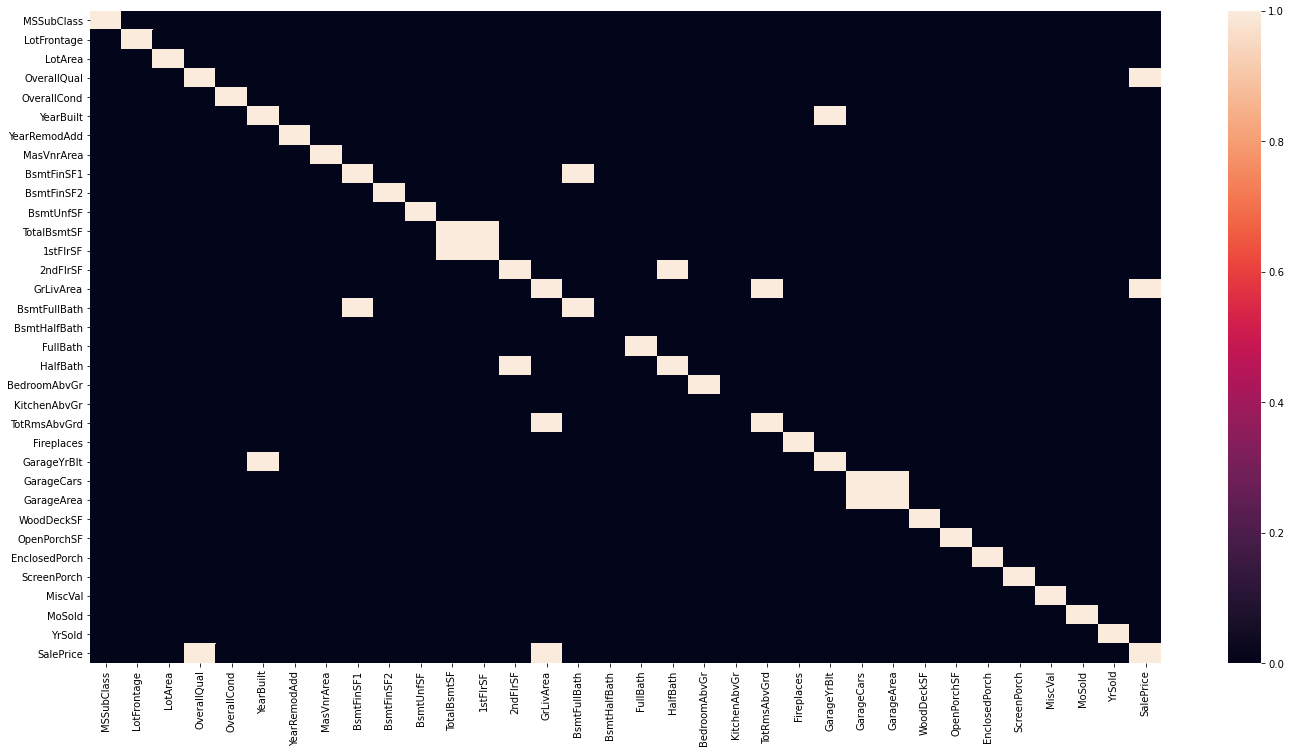

In [19]:
# Zoome View for highlighted features
plt.figure(figsize=(24, 12))
sns.heatmap(corr_matrix > 0.7)

#### Summary :
    1. We could drop the highly co-related features, but we are not sure of the multi-colinearity. So we will lte RFE or the Regularised Regression select the features.

## Step 3 : Variable Manipulation

#### Derived | Dummy | Outliers

In [20]:
# Some Categorical Values have order in them. We Rank them accordingly

data['LandSlope'] = data.LandSlope.map({'Gtl':0,'Mod':1,'Sev':2})
data['ExterQual'] = data.ExterQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
data['BsmtQual'] = data.BsmtQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
data['BsmtCond'] = data.BsmtCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
data['BsmtExposure'] = data.BsmtExposure.map({'NA':0,'No':1,'Mn':2,'Av':3,'Gd':4})
data['BsmtFinType1'] = data.BsmtFinType1.map({'NA':0,'Unf':1,'LwQ':2,'Rec':3,'BLQ':4,'ALQ':5,'GLQ':6})
data['HeatingQC'] = data.HeatingQC.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
data['CentralAir'] = data.CentralAir.map({'N':0,'Y':1})
data['KitchenQual'] = data.KitchenQual.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
data['GarageFinish'] = data.GarageFinish.map({'NA':0,'Unf':1,'RFn':2,'Fin':3})
data['GarageQual'] = data.GarageQual.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
data['GarageCond'] = data.GarageCond.map({'NA':0,'Po':1,'Fa':2,'TA':3,'Gd':4,'Ex':5})
data['ExterCond'] = data.ExterCond.map({'Po':0,'Fa':1,'TA':2,'Gd':3,'Ex':4})
data['LotShape'] = data.LotShape.map({'IR1':0,'IR2':1,'IR3':2,'Reg':3})

# Also since many Variable have NA which Panda  would detect as NaN.
# We fill it with 0 as per the mapping
data = data.fillna(0)

In [21]:
# Removing Orderd Categorical Columns

cat_col = list(set(cat_col)-set(['LandSlope','ExterQual','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','HeatingQC',
                                'CentralAir','KitchenQual','GarageFinish','GarageQual','GarageCond','ExterCond','LotShape']))

# Adding Dummy Columns for Categorical Features
for col in cat_col:
    #Drop-First = True as we want n-1 columns for n categories
    dummies = pd.get_dummies(data[col], drop_first = True)
    
    # To identify the column, adding prefix
    dummies = dummies.add_prefix(f'{col}_')
    
    # Merging the results
    data = pd.concat([data, dummies], axis = 1)
    
    # Drop original column 
    data.drop([col], axis = 1, inplace = True)

print("New Dimesion After changing Categorical Columns : {}".format(data.shape))

New Dimesion After changing Categorical Columns : (1003, 182)


In [22]:
## Changing Date Values to  more derived features

# Adding as reference date
data['CurrentYear'] = datetime.datetime.now().year

# How old is the property
data['Age'] = data['CurrentYear'] - data["YearBuilt"]
# years since it was remodelled
data['Remodel_Age'] = data['CurrentYear'] - data["YearRemodAdd"]
# How old is the Garage
data['Garage_Age'] = data['CurrentYear'] - data["GarageYrBlt"]
# Years since it was last sold
data['Last_Sold'] = data['CurrentYear'] - data["YrSold"]

# Dropping Actual Columns
data = data.drop(['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold'],axis='columns')


print("Data Size : {}".format(data.shape))
data[["Age","Remodel_Age","Garage_Age","Last_Sold"]].head()

Data Size : (1003, 183)


,Age,Remodel_Age,Garage_Age,Last_Sold
0,17,17,17.0,12
2,19,18,19.0,12
4,20,20,20.0,12
5,27,25,27.0,11
6,16,15,16.0,13


In [23]:
# Updating the Numerical Columns List 
num_col = list(set(num_col) - set(['YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']))

## Step 4 : Dataset Creation

#### Splitting & Scaling Dataset

In [24]:
# Split the dataset

X_train,X_test = train_test_split(data,train_size=0.8,test_size=0.2,random_state=42)

print("Training Size : {}".format(X_train.shape[0]))
print("Test Size : {}".format(X_test.shape[0]))

Training Size : 802
Test Size : 201


In [25]:
# Separating the Target Variable
y_train =  X_train.pop("SalePrice")
y_test =  X_test.pop("SalePrice")

scaler = MinMaxScaler()
X_train[num_col] = scaler.fit_transform(X_train[num_col])
X_test[num_col] = scaler.transform(X_test[num_col])

print("Training Data Size : {}".format(X_train.shape))
print("Test Data Size : {}".format(X_test.shape))

Training Data Size : (802, 182)
Test Data Size : (201, 182)



## Step 5. Modelling

#### Feature Selection | Lasso Regression | Ridge Regression

In [26]:
# Using RFE with a Linear Regression Model to subselect feature

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, 50)             # running RFE and selecting 50 features best describing Target Variable
rfe = rfe.fit(X_train, y_train)
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('MSSubClass', True, 1),
 ('LotFrontage', False, 96),
 ('LotArea', True, 1),
 ('LotShape', False, 113),
 ('LandSlope', False, 102),
 ('OverallQual', True, 1),
 ('OverallCond', True, 1),
 ('MasVnrArea', False, 40),
 ('ExterQual', False, 39),
 ('ExterCond', False, 57),
 ('BsmtQual', False, 16),
 ('BsmtCond', False, 91),
 ('BsmtExposure', False, 77),
 ('BsmtFinType1', False, 103),
 ('BsmtFinSF1', True, 1),
 ('BsmtFinSF2', False, 2),
 ('BsmtUnfSF', True, 1),
 ('TotalBsmtSF', True, 1),
 ('HeatingQC', False, 121),
 ('CentralAir', False, 63),
 ('1stFlrSF', False, 87),
 ('2ndFlrSF', True, 1),
 ('GrLivArea', True, 1),
 ('BsmtFullBath', False, 85),
 ('BsmtHalfBath', False, 127),
 ('FullBath', False, 88),
 ('HalfBath', False, 86),
 ('BedroomAbvGr', True, 1),
 ('KitchenAbvGr', False, 126),
 ('KitchenQual', False, 67),
 ('TotRmsAbvGrd', False, 97),
 ('Fireplaces', False, 98),
 ('GarageFinish', False, 92),
 ('GarageCars', True, 1),
 ('GarageArea', False, 82),
 ('GarageQual', False, 125),
 ('GarageC

In [27]:
print("Columns Selected by RFE : {}".format(X_train.columns[rfe.support_]))
print()
print("Columns Rejected by RFE : {}".format(X_train.columns[~rfe.support_]))

Columns Selected by RFE : Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'BsmtFinSF1',
       'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr',
       'GarageCars', 'WoodDeckSF', 'Neighborhood_NAmes', 'Neighborhood_NWAmes',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_StoneBr',
       'FireplaceQu_Fa', 'SaleType_CWD', 'SaleType_Con', 'SaleType_ConLI',
       'SaleType_Oth', 'BldgType_2fmCon', 'BldgType_Twnhs', 'BldgType_TwnhsE',
       'BsmtFinType2_GLQ', 'BsmtFinType2_No Basement', 'Heating_Wall',
       'MSZoning_FV', 'MSZoning_RL', 'MSZoning_RM', 'Functional_Mod',
       'Functional_Typ', 'LandContour_HLS', 'Condition1_RRAe',
       'Condition1_RRNe', 'PavedDrive_P', 'HouseStyle_2Story',
       'HouseStyle_SFoyer', 'HouseStyle_SLvl', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Partial', 'Exterior1st_CemntBd',
       'Exterior1st_Stucco', 'Exterior1st_Wd Sdng', 'Exterior2nd_CmentBd',
       'Exterior

In [28]:
# Filtering Features based on RFE

X_train_rfe = X_train[X_train.columns[rfe.support_]]
X_test_rfe = X_test[X_test.columns[rfe.support_]]

print("Train Data : {}".format(X_train.shape))
print("Test Data : {}".format(X_test.shape))
print("**********************")
print("Train Data : {}".format(X_train_rfe.shape))
print("Test Data : {}".format(X_test_rfe.shape))

Train Data : (802, 182)
Test Data : (201, 182)
**********************
Train Data : (802, 50)
Test Data : (201, 50)


#### Common Function

In [29]:
# Common Predict Function for any model
def predict(model,train=X_train,test=X_test) :
    
    # predict train
    y_train_pred = model.predict(train)
    # predict test
    y_test_pred = model.predict(test)
    
    return y_train_pred,y_test_pred

# Common Function to print R-squared value for Train & Test Set 
def r2(y_train_pred,y_test_pred,model_name="Linear Regression") :
    print("R2 on {} Training  : {}".format(model_name,r2_score(y_train,y_train_pred)))
    print("R2 on {} Test  : {}".format(model_name,r2_score(y_test, y_test_pred)))
    

# Common Function to Plot results for Alpha
def plot_cv_results(model_cv,threshold=200) :
    
    cv_results = pd.DataFrame(model_cv.cv_results_)
    cv_results = cv_results[cv_results['param_alpha']<=threshold]
    
    # plotting mean test and train scores with alpha 
    cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

    # plotting
    plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
    plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
    plt.xlabel('alpha')
    plt.ylabel('Negative Mean Absolute Error')
    plt.title("Negative Mean Absolute Error and alpha")
    plt.legend(['train score', 'test score'], loc='upper left')
    plt.show()
    

### Model 1 : Baseline Linear Regression

In [30]:
lm = LinearRegression()
lm.fit(X_train, y_train)

y_train_pred,y_test_pred = predict(lm)
r2(y_train_pred,y_test_pred,model_name="Linear Regression")

R2 on Linear Regression Training  : 0.9345098137623105
R2 on Linear Regression Test  : 0.9132084420592852


#### Summary :
1.  We can see the model is overfitting due to the high difference in the train & test set performance.
2. Hence we will now try Regularised Regression 

In [31]:
# list of alphas to tune during K-Fold Grid Search

params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

### Model 2 : Ridge Linear Regression  (with RFE features)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    3.5s finished


Best Alpha : {'alpha': 0.9}


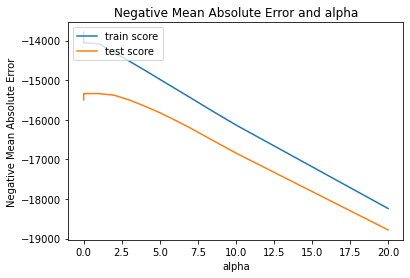

In [33]:
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1,n_jobs=-1)            
model_cv.fit(X_train_rfe, y_train) 

print("Best Alpha : {}".format(model_cv.best_params_))
# PLot the results on Alpha. Set Threshold to visualise to scale
plot_cv_results(model_cv,threshold=20)

In [34]:
# The best test performance is at alpha = 
alpha = model_cv.best_params_['alpha']
ridge = Ridge(alpha)
ridge.fit(X_train_rfe, y_train)

y_train_pred_m2,y_test_pred_m2 = predict(ridge,train=X_train_rfe,test=X_test_rfe)
r2(y_train_pred_m2,y_test_pred_m2,model_name="Ridge Regression")

R2 on Ridge Regression Training  : 0.9052466933470691
R2 on Ridge Regression Test  : 0.916421900027934


### Model 3 : Ridge Linear Regression (All Features)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.6s finished


Best Alpha : {'alpha': 3.0}


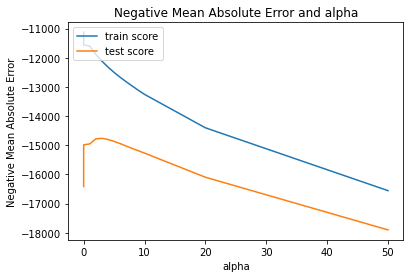

In [35]:
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1,n_jobs=-1)            
model_cv.fit(X_train, y_train) 

print("Best Alpha : {}".format(model_cv.best_params_))
# PLot the results on Alpha. Set Threshold to visualise to scale
plot_cv_results(model_cv,threshold=50)

In [36]:
# The best test performance is at alpha = 
alpha = model_cv.best_params_['alpha']
ridge = Ridge(alpha=alpha) #3
ridge.fit(X_train, y_train)

y_train_pred_m3,y_test_pred_m3 = predict(ridge,train=X_train,test=X_test)
r2(y_train_pred_m3,y_test_pred_m3,model_name="Ridge Regression")

R2 on Ridge Regression Training  : 0.9267171588173613
R2 on Ridge Regression Test  : 0.9270709271883406


#### Model 4 : Lasso Linear Regression (with RFE features)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    0.8s finished


Best Alpha : {'alpha': 20}


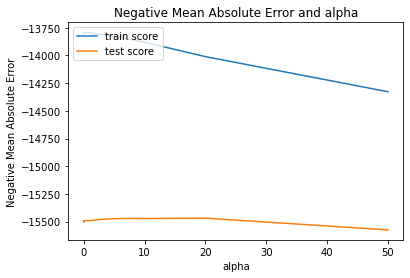

In [41]:
lasso = Lasso()

# cross validation
folds = 5

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1,n_jobs=-1)            

model_cv.fit(X_train_rfe, y_train) 

print("Best Alpha : {}".format(model_cv.best_params_))
# PLot the results on Alpha. Set Threshold to visualise to scale
plot_cv_results(model_cv,threshold=50)

In [42]:
# The best test performance is at alpha = 

alpha = model_cv.best_params_['alpha']
lasso = Lasso(alpha=alpha)
lasso.fit(X_train_rfe, y_train)

y_train_pred_m4,y_test_pred_m4 = predict(lasso,train=X_train_rfe,test=X_test_rfe)
r2(y_train_pred_m4,y_test_pred_m4,model_name="Lasso Regression")

R2 on Lasso Regression Training  : 0.9056536308267849
R2 on Lasso Regression Test  : 0.9153690144571331


### Model 5 : Lasso Linear Regression (with All features)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:    7.5s finished


Best Alpha : {'alpha': 100}


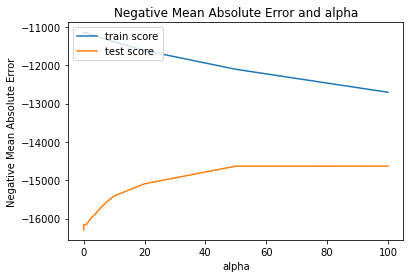

In [39]:
lasso = Lasso()

# cross validation
folds = 5

# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1,n_jobs=-1)            

model_cv.fit(X_train, y_train) 

print("Best Alpha : {}".format(model_cv.best_params_))
# PLot the results on Alpha. Set Threshold to visualise to scale
plot_cv_results(model_cv,threshold=200)

In [40]:
# The best test performance is at alpha = 

alpha = model_cv.best_params_['alpha']
lasso = Lasso(alpha=alpha)
lasso.fit(X_train, y_train)

y_train_pred_m5,y_test_pred_m5 = predict(lasso,train=X_train,test=X_test)
r2(y_train_pred_m5,y_test_pred_m5,model_name="Lasso Regression")

R2 on Lasso Regression Training  : 0.9186329423935795
R2 on Lasso Regression Test  : 0.9266551663376201


## Performance Analysis
1. We tried Ridge & Lasso regression with all the features we create & 50 top features selected by RFE
2. For **Ridge Regression** we observe :  
    i. **All Features** Model (alpha = 3.0 ): R2 is 0.927 with ~180 features  
    ii. **RFE Features** Model (alpha = 0.9 ) : R2 is 0.916 with 50 features  
3. For **Lasso Regression** we observe :  
    i. **All Features** Model (alpha = 100 ) : R2 is 0.926 with ~180 features  
    ii. **RFE Features** Model (alpha = 20 ) : R2 is 0.915 with 50 features  
4. It should be observed that model with lesser features with almost similar performace is better. Hence we will prefer models using only 50 features.
5. Also, since we explicitly handled outliers in our dataset, Ridge & Lasso have very similar performance.
6. It should be noted, that outliers affect Ridge Regression more than Lasso

## Step 6: Model Evaluation & Selection

In [43]:
# Calculate the VIFs for  model
def get_vif(X_train):
    vif = pd.DataFrame()
    X = X_train
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

def plot_pred(test,pred,idx,title="") :
#     fig = plt.figure()
    ax = plt.subplot(2,2,idx)
    plt.scatter(test, pred)
    ax.set_title(title)
    plt.xlabel('y_test', fontsize = 10) # Y-label                     
    plt.ylabel('y_pred', fontsize = 10) # X-label
    
def plot_error(train,pred,idx,title="") :
    # Plot the histogram of the error terms
    plt.subplot(2,2,idx)
    ax = sns.distplot((train - pred), bins = 15)
    ax.set_title(title)
    plt.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
    plt.xlabel('Errors', fontsize = 12)   

def plot_prediction(index,label,pred,idx,title="") :
    # Plot the histogram of the error terms
    ax = plt.subplot(4,1,idx)
    plt.plot(index,label,color="blue")
    plt.plot(index,pred,color="red")
    ax.set_title(title)
    plt.suptitle('Actual v/s Predicted', fontsize = 20)                  # Plot heading 
#     plt.xlabel('Errors', fontsize = 18) 

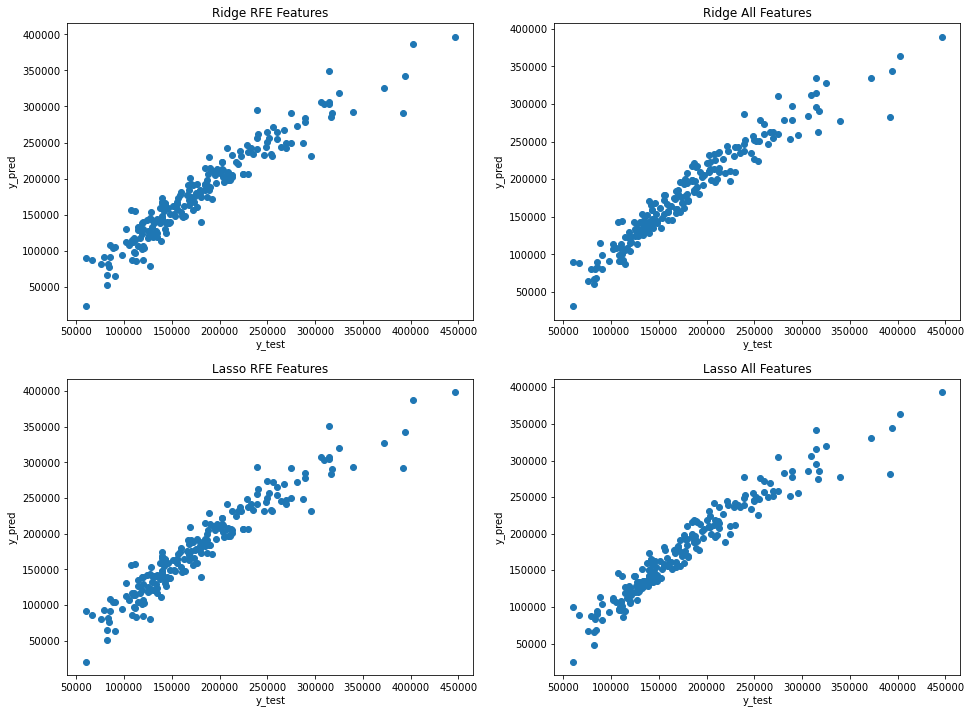

In [44]:
# Plot Y-Test v/s Y-Pred , showing linear relationship. Hence we can say to have a good model

plt.figure(figsize=(16, 12))
plot_pred(y_test,y_test_pred_m2,1,title="Ridge RFE Features")
plot_pred(y_test,y_test_pred_m3,2,title="Ridge All Features")
plot_pred(y_test,y_test_pred_m4,3,title="Lasso RFE Features")
plot_pred(y_test,y_test_pred_m5,4,title="Lasso All Features")

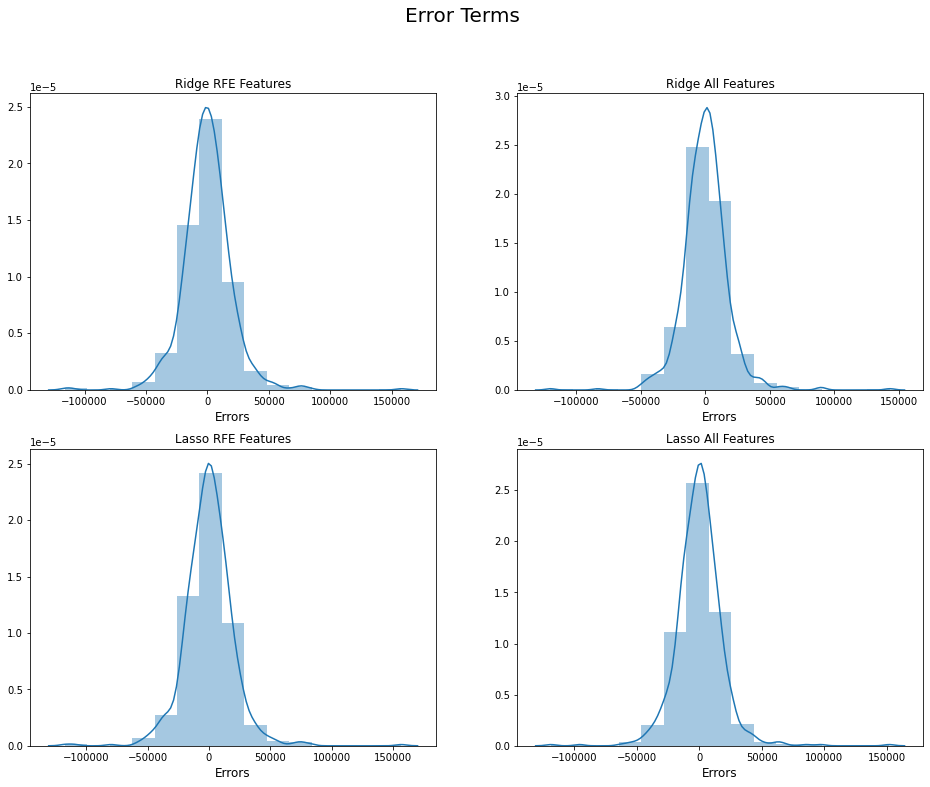

In [45]:
# Error Term Distribution for Training Dataset validating Linear Regression Assumptions

plt.figure(figsize=(16, 12))
plot_error(y_train,y_train_pred_m2,1,title="Ridge RFE Features")
plot_error(y_train,y_train_pred_m3,2,title="Ridge All Features")
plot_error(y_train,y_train_pred_m4,3,title="Lasso RFE Features")
plot_error(y_train,y_train_pred_m5,4,title="Lasso All Features")

## Conclusion
1. Based on the above relationship b/w y-test & y-pred & error term distribution, the best model for us would be **Lasso Regression** over RFE selected features.
2. The details of the model are :   
    i. **alpha** = 20  
    ii. **R Squared** = 0.916

## Step 7 : Significant Features

In [70]:
# best model 
lasso = Lasso(alpha=20)
lasso.fit(X_train_rfe, y_train)

Lasso(alpha=20, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [72]:
model_coef = list(lasso.coef_)
model_coef.insert(0,lasso.intercept_)
cols = X_train_rfe.columns
cols.insert(0,'constant')
lasso_coef = pd.DataFrame(list(zip(cols,model_coef)))
lasso_coef.columns = ['Feature','Coef']

top_5_pos = lasso_coef.sort_values(by="Coef",ascending=False)["Feature"].head(5).tolist()
top_5_neg = lasso_coef.sort_values(by="Coef",ascending=True)["Feature"].head(5).tolist()

print("The Variables that positively/directly affect the price of a house are : {}".format(top_5_pos))
print()
print("The Variables that negatively/indirectly affect the price of a house are : {}".format(top_5_neg))

The Variables that positively/directly affect the price of a house are : ['BedroomAbvGr', 'OverallCond', '2ndFlrSF', 'SaleType_Con', 'BsmtUnfSF']

The Variables that negatively/indirectly affect the price of a house are : ['LotArea', 'MSSubClass', 'SaleCondition_Partial', 'Exterior2nd_CmentBd', 'Neighborhood_NridgHt']


#### Inference
1. The top 5 features which affect the prices are :  
    i. **BedroomAbvGr**  
    ii. **OverallCond**   
    iii. **2ndFlrSF**   
    iv. **LotArea**   
    v. **SaleType_Con**   


2. Properties of the house which positively affect the prices are :   
    i. **BedroomAbvGr**  
    ii. **OverallCond**  
    iii. **2ndFlrSF**  
    iv. **2ndFlrSF**  
    v. **BsmtUnfSF**  
    

3. Properties of the house which negatively affect the prices are :   
    i. **LotArea**  
    ii. **MSSubClass**  
    iii. **SaleCondition_Partial**  
    iv. **Exterior2nd_CmentBd**  
    v. **Neighborhood_NridgHt**  